In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, validation_curve, cross_val_score, StratifiedShuffleSplit, StratifiedKFold

In [ ]:
import psycopg2
import pandas as pd

# Database connection parameters (replace with your own)
db_params = {
    "dbname": "phishing_db",
    "user": "postgres",
    "password": "Alk0H4wk19?",
    "host": "localhost",
    "port": "5432"
}

# Chunk size and target sample size
chunk_size = 50000
target_samples = 150000  # You only want 150,000 samples per table

# Function to export table in chunks up to target_samples
def export_table_to_csv(table_name, db_params, chunk_size, target_samples):
    # Connect to the database
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()
    
    # Get total row count
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    total_rows = cursor.fetchone()[0]
    print(f"Total rows in {table_name}: {total_rows}")
    
    # Check if the table has enough rows
    if total_rows < target_samples:
        print(f"Warning: {table_name} only has {total_rows} rows, less than the requested {target_samples} samples.")
        target_samples = total_rows  # Adjust target to available rows
    
    # Calculate number of chunks needed to reach target_samples
    num_chunks = (target_samples // chunk_size) + (1 if target_samples % chunk_size else 0)
    
    # Track total rows fetched
    total_fetched = 0
    
    # Fetch and export each chunk
    for i in range(num_chunks):
        # Break if we've already fetched enough rows
        if total_fetched >= target_samples:
            break
        
        offset = i * chunk_size
        # Adjust the LIMIT to not fetch more than needed
        remaining_rows = target_samples - total_fetched
        current_chunk_size = min(chunk_size, remaining_rows)
        
        query = f"SELECT * FROM {table_name} LIMIT {current_chunk_size} OFFSET {offset}"
        
        # Fetch chunk into a DataFrame
        df = pd.read_sql_query(query, conn)
        
        # Update total rows fetched
        total_fetched += len(df)
        
        # Save to CSV
        csv_filename = f"{table_name}_chunk_{i+1}.csv"
        df.to_csv(csv_filename, index=False)
        print(f"Saved {csv_filename} with {len(df)} rows")
    
    print(f"Total rows fetched from {table_name}: {total_fetched}")
    
    # Close connection
    cursor.close()
    conn.close()

# Export both tables
tables = ["benign_2022", "phishing_2022"]
for table in tables:
    print(f"Exporting {table}...")
    export_table_to_csv(table, db_params, chunk_size, target_samples)

Exporting benign_2022...
Total rows in benign_2022: 3592391


/tmp/ipykernel_4830/4146573552.py:53: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [5]:
# Example: Load and process one chunk at a time
for i in range(1, 8):  # Adjust range based on number of chunks for 'benign'
    chunk_file = f"benign_2022_chunk_{i}.csv"
    df_chunk = pd.read_csv(chunk_file)
    print(f"Processing {chunk_file} with {len(df_chunk)} rows")

Processing benign_2022_chunk_1.csv with 50000 rows


FileNotFoundError: [Errno 2] No such file or directory: 'benign_2022_chunk_2.csv'

In [9]:
df.head()

,id,datetime,url,title,source_code,redirected_urls,header_info,certificate_information,screenshot_id,label
0,1773,2022-07-23 14:50:15.804017,https://www.cognitoforms.com/Agt12/OUTLOOK,OUTLOOK | Cognito Forms,"<html lang=""en"" class=""cog-public-form""><head>...",NaN,"{\n ""cache-control"": ""no-cache, no-store, mus...","{\n ""OCSP"": [\n ""http://ocsp.godaddy.com/""...",2022_07_23_14_50_15_www.cognitoforms.com.png,1
1,426265,2021-08-15 00:00:00,https://regularizacomclientes.com/itokendoscli...,Nan,"<html lang=""pt-br"" class=""js flexbox flexboxle...",Nan,Nan,Nan,Nan,1
2,50017,2022-10-18 21:36:34.652189,https://accounts.google.com/v3/signin/identifi...,Sign in - Google Accounts,"<html lang=""en-US"" dir=""ltr"" class=""eC9N2e""><h...",{https://sites.google.com/view/directionobweb/...,"{\n ""content-type"": ""text/html; charset=utf-8...","{\n ""OCSP"": [\n ""http://ocsp.pki.goog/gts1...",2022_10_18_21_36_34_accounts.google.com.png,1
3,419524,2021-08-15 00:00:00,http://1itaunet-sempre-lado-a-lado-com-voce.00...,Nan,"<html lang=""en-us""><head>\n <script async=""...",Nan,Nan,Nan,Nan,1
4,547035,2021-08-15 00:00:00,https://www.alfazen.com.tr/Entscheidung-289766...,Nan,"<html lang=""en"" class=""font-marketsans""><head>...",Nan,Nan,Nan,Nan,1


In [10]:
df['url_length'] = df['url'].apply(len) # Calculates length of each url and stores in new column called url_length
df['num_subdomains'] = df['url'].apply(lambda x: x.count('.') - 1) # Counts the number of subdomains and stores in new column called num_subdomains
df['has_https'] = df['url'].apply(lambda x: 1 if x.startswith('https') else 0) 
df['num_hyphens'] = df['url'].apply(lambda x: x.count('-'))
df['num_special_chars'] = df['url'].apply(lambda x: sum(x.count(char) for char in ['@', '%', '#', '$']))
suspicious_keywords = ['login', 'secure', 'account', 'verify', 'update', 'password']
df['has_suspicious_keyword'] = df['url'].apply(lambda x: 1 if any(keyword in x.lower() for keyword in suspicious_keywords) else 0)
df['num_external_links'] = df['source_code'].apply(lambda x: str(x).lower().count('href='))

In [11]:
# List of columns to drop
columns_to_drop = ['id', 'datetime', 'url', 'title', 'source_code', 'redirected_urls', 'header_info', 
                   'certificate_information', 'screenshot_id',]

# Drop the columns
df = df.drop(columns=columns_to_drop)


In [12]:
df.head()

,label,url_length,num_subdomains,has_https,num_hyphens,num_special_chars,has_suspicious_keyword,num_external_links
0,1,42,1,1,0,0,0,8
1,1,70,1,1,0,0,0,13
2,1,384,5,1,3,13,1,6
3,1,70,2,0,6,0,0,8
4,1,164,4,1,7,1,0,22


In [13]:
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
clf = DecisionTreeClassifier()
cv = StratifiedKFold(n_splits = 5)
scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring='f1')
print(scores)
print(scores.mean())

[0.86942973 0.85461999 0.85732283 0.86247234 0.85559452]
0.8598878821340058


In [15]:
ss_split = StratifiedShuffleSplit(n_splits = 100, test_size=.25)
scores_ss = cross_val_score(clf, X_train, y_train, cv = ss_split, scoring = 'f1')

In [16]:
scores_ss

array([0.85447196, 0.85979433, 0.86224233, 0.86807654, 0.8671992 ,
       0.87173038, 0.8591692 , 0.85110664, 0.85671192, 0.8585144 ,
       0.86841435, 0.85447196, 0.85822785, 0.86344059, 0.86564924,
       0.85908405, 0.86023127, 0.85598583, 0.86595852, 0.85570385,
       0.85542169, 0.86093047, 0.86844758, 0.86613387, 0.86001508,
       0.85986463, 0.85980367, 0.8556204 , 0.86294162, 0.86325863,
       0.86015566, 0.86664986, 0.86157761, 0.85721468, 0.86307264,
       0.85951662, 0.86551465, 0.86350975, 0.86934799, 0.85619582,
       0.86375063, 0.856002  , 0.86419753, 0.86865149, 0.85793731,
       0.86814588, 0.86374017, 0.85250063, 0.87192241, 0.85317861,
       0.86195625, 0.85950828, 0.87070707, 0.86779149, 0.85558313,
       0.85635081, 0.87058824, 0.86404834, 0.85435435, 0.85878818,
       0.85721493, 0.86804853, 0.85921118, 0.8578629 , 0.86876248,
       0.86143824, 0.85714286, 0.86124402, 0.85499247, 0.85945399,
       0.86941323, 0.85922208, 0.86285425, 0.86603725, 0.86107

In [17]:
scores_ss.mean()

0.8612643148376994

<Figure size 1000x600 with 0 Axes>

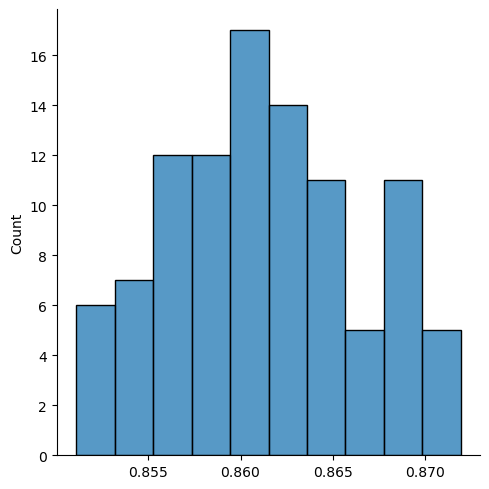

In [18]:
plt.figure(figsize=(10,6))
sns.displot(scores_ss, bins=10);

In [19]:
import scipy

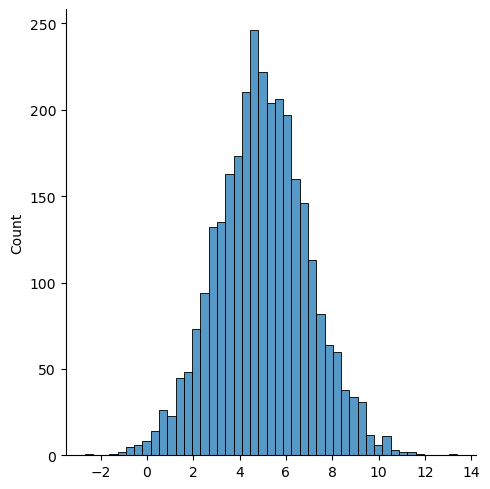

In [20]:
sns.displot(scipy.stats.norm(5, scale=2).rvs(3000));

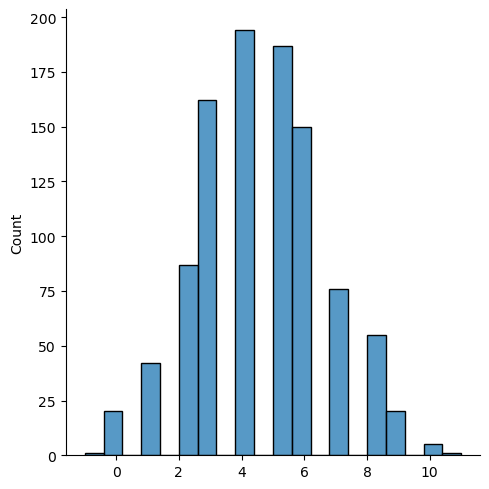

In [21]:
numbers = scipy.stats.norm(5, scale=2).rvs(1000)
sns.displot(numbers.astype(int));

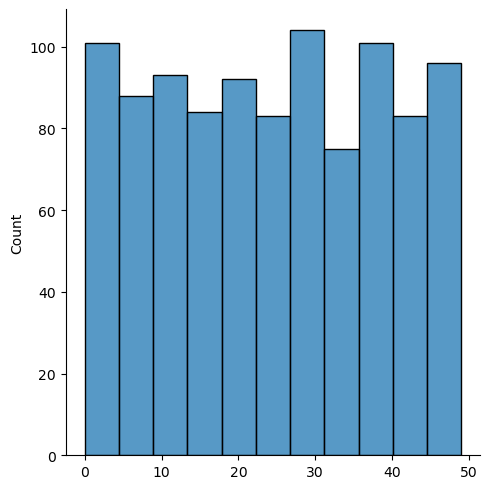

In [22]:
sns.displot(scipy.stats.randint(0,50).rvs(1000));

In [31]:
dtc = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20)
ada = AdaBoostClassifier(dtc, n_estimators=100)

In [ ]:

params = {'max_depth': scipy.stats.randint(2,100), 'min_samples_leaf': scipy.stats.randint(2,50), 'min_samples_split': scipy.stats.randint(2,50)}

In [24]:
rand_search = RandomizedSearchCV(clf, params, n_iter=4, scoring='f1', n_jobs= -1, cv = StratifiedKFold(n_splits=5))

In [25]:
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(), n_iter=4, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73bc14a35fa0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73bc1493cbc0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x73bc1493e1b0>},
                   scoring='f1')

In [26]:
rand_search.best_score_

0.8915712145667938

In [27]:
rand_search.best_params_

{'max_depth': 64, 'min_samples_leaf': 18, 'min_samples_split': 38}